In [1]:
# %matplotlib inline
# !pip install torchsummary

In [2]:
# Standard libnrary imports
import albumentations as A
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep

# Custom library imports
from main import Cifar10Dataset
from utils import show_grid
from main import train, valid, cycle_lr
from utils import plot_loss_update
from models.resnet import ResNet

# Tensorboard imports
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2021-12-07 01:44:39.722630: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Configurable Parameters

In [3]:
params = dict(
    augmentation = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize()
    ],
    batch_size = 512,
    split = 0.8,
    # optimizer = optim.SGD(),
    criterion = nn.CrossEntropyLoss(),
    epochs = 10,
    max_at_epoch = 5,
    writer = writer,
    freq = 999,
    lr = [0.01, 0.001],
    shuffle = [True, False]
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [4]:
transform = A.Compose(params['augmentation'])

dataset = Cifar10Dataset(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*params['split']), int(round(1.0-params['split'],2)*len(dataset))])

testset = Cifar10Dataset(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=params['batch_size'], shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], shuffle=False, num_workers=2)
params['classes'] = dataset.classes

Files already downloaded and verified
Files already downloaded and verified


### Display image grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat   ship  plane  truck   deer   ship    cat   bird    cat    dog    car  horse    dog   frog    cat    car   deer   ship   bird  truck


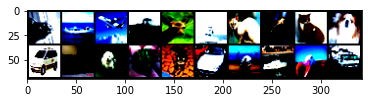

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
grid = show_grid(images, labels, max = 20)
# write to tensorboard
# grid_rgb = np.transpose(grid, (1,2,0))
writer.add_image('CIFAR10 data images', grid)
# writer.close()

## Model

from models.resnet import Net
from torchsummary import summary

net = Net().to(device)

print(device)
summary(net, input_size=(3, 32, 32))

In [6]:
net = ResNet().to(device)
print('device', device)
summary(net, input_size=(3, 32, 32))
# inputs = np.transpose(images,(0,3,1,2)).to(device)
# writer.add_graph(net, inputs)

device cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14     

/home/wenisch/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Search for LR

In [7]:
import math
# lr = 0.01
start_lr = 0.001
end_lr = 1.5
lr_find_epochs = 1
criterion = params['criterion'] #nn.CrossEntropyLoss()
params['optimizer'] = optim.SGD(net.parameters(), lr=start_lr,
                      momentum=0.9, weight_decay=5e-4)
lambda1 = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(trainloader)))
scheduler = torch.optim.lr_scheduler.LambdaLR(params['optimizer'], lr_lambda=lambda1)


In [8]:
lr_find_lr, lr_find_loss = cycle_lr(trainloader, net, params, scheduler, lr_find_epochs)

epoch 0
epoch 1


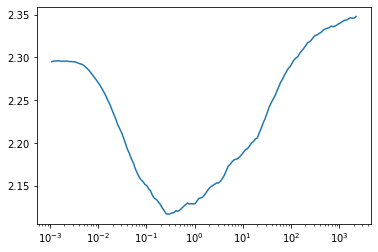

In [9]:
plt.plot(lr_find_lr, lr_find_loss)
plt.xscale("log")

In [10]:
# Calculate from above method
lr_max = 0.3
max_at_epoch = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=params['optimizer'], max_lr=lr_max, steps_per_epoch=len(trainloader), epochs=params['epochs'])

In [11]:
mb = master_bar(range(1, params['epochs']+1))
train_loss, valid_loss = [], []
for epoch in mb:
    params['epoch'], params['mb'] = epoch, mb
    train_loss, train_acc = train(trainloader, net, params, train_loss, scheduler, freq = 10)
    valid_loss, val_acc = valid(valloader, net, params, valid_loss)
    
    params['writer'].add_scalar('lr_scheduler', scheduler.get_last_lr()[-1], params['epoch']+1)
    params['writer'].add_scalar('lr_training loss', train_loss[-1], scheduler.get_last_lr()[-1])
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished epoch {epoch}, Test Loss {valid_loss[-1]:0.6f}, Train Accuracy {train_acc:0.2f}, Val Accuracy {val_acc:0.2f}')
    # plot_loss_update(epoch, params['epochs'], mb, train_loss, valid_loss)
writer.close()

Saving..


KeyboardInterrupt: 

# Test Model

## Load model

In [ ]:
import torch
from models.resnet import ResNet18
from main import Cifar10Dataset
import albumentations as A

In [ ]:
PATH = "./checkpoint/ckpt.pth"
checkpoint = torch.load(PATH)

In [ ]:
# Inspect the model using TensorBoard
writer.add_graph(net, images)
writer.close()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
model.load_state_dict(checkpoint['net'])

In [ ]:
transform = A.Compose([
    A.Normalize()
    ])

testset = Cifar10Dataset(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

### List wrongly classified images

In [ ]:
from fastprogress.fastprogress import master_bar, progress_bar
import torch.nn as nn

import numpy as np

model.eval()
mb = master_bar(range(1, 2))
pbar_eval = progress_bar(testloader,  parent=mb)
wrong_images = [] # torch.Tensor()
j= 0
correct = 0
total = 0
for epoch in mb:
    for i, data in enumerate(pbar_eval):
        images, labels = data
        images, labels = np.transpose(images,(0,3,1,2)).to(device).to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predictions.eq(labels).sum().item()
        if all(predictions.eq(labels)) is False:
            for img in images[predictions!=labels]:
                wrong_images.append(img.unsqueeze(dim=0))
            j = j+len(images[predictions!=labels])
            if j>20:
                print("20 errors found go fix it")
                break
        mb.child.comment = f'Test Accuracy={100*correct/total:0.2f}'
print(f'Accuracy: ={100*correct/total:0.2f}')
wrong_images = torch.stack(wrong_images,0).squeeze()

In [ ]:
from utils import show_grid

img_grid = show_grid(wrong_images.to('cpu'), max = 20, channel_change = (0,1,2,3))
# write to tensorboard
# writer.add_image('Wrongly Classified images', img_grid)

In [ ]:
from utils import plot_classes_preds
writer.add_figure('predictions vs. actuals', plot_classes_preds(net, img_grid, labels), global_step=epoch * len(trainloader) + i)

## Gradcam

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.layer4[-1]]
input_tensor = images #.permute(0,3,1,2)
# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

grad_img = []
with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    target_category = 7
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
    grad_img.append(grayscale_cam)

In [ ]:
array = input_tensor.permute(0,2,3,1).to('cpu').numpy()
visualization = show_cam_on_image(array, grayscale_cam, use_rgb=True)

In [ ]:
import torchvision

array = input_tensor.permute(0,2,3,1).to('cpu').numpy() #np.transpose(input_tensor[0],(1,2,0)).numpy()

grid = torchvision.utils.make_grid(grad_img[:max], nrow=10)
# plt.figure(figsize=(15,15))
plt.figure()
visualization = show_cam_on_image(grid, grid, use_rgb=True)
plt.imshow(np.transpose(grid, (1,2,0)))

In [ ]:
input_tensor.shape

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(array[0])

In [ ]:
plt.imshow(visualization)

In [ ]:
plt.imshow(grayscale_cam[0])

In [ ]:
grayscale_cam.shape

In [ ]:
array.shape

In [ ]:
visualization.shape